In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib as mp

import seaborn as sns 
sns.set_style('darkgrid')

import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from wordcloud import WordCloud

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


from tqdm.notebook import tqdm; tqdm.pandas();

In [2]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [3]:
with open('content/input/stopwords/stopwords.txt','r') as file: 
    stop_words = [row.strip() for row in file]

In [4]:
df = pd.read_csv('content/input/sentiment-analysis-for-mental-health/Combined Data.csv',index_col = 'Unnamed: 0')
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
df.shape

(53043, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [7]:
df.isnull().sum()

statement    362
status         0
dtype: int64

In [8]:
df[df.statement.isnull()] # Chech where the values are Null 

,statement,status
293,NaN,Anxiety
572,NaN,Anxiety
595,NaN,Anxiety
1539,NaN,Normal
2448,NaN,Normal
...,...,...
52838,NaN,Anxiety
52870,NaN,Anxiety
52936,NaN,Anxiety
53010,NaN,Anxiety


In [9]:
df = df[~df.statement.isna()] # Delete all rows with Null values

In [10]:
df.reset_index(drop = True, inplace = True)

In [11]:
df

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
52676,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
52677,"selfishness ""I don't feel very good, it's lik...",Anxiety
52678,Is there any way to sleep better? I can't slee...,Anxiety
52679,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [12]:
df.status.value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

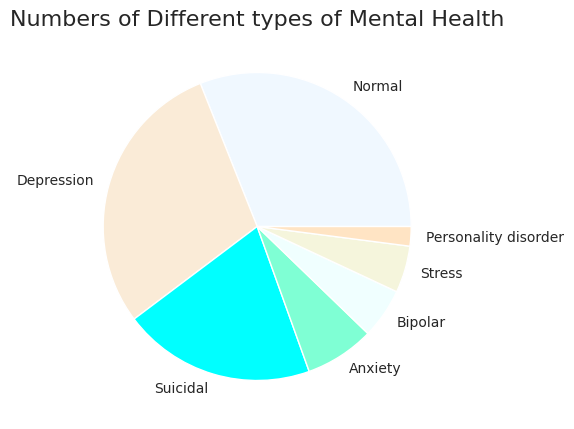

In [13]:
fig, ax = plt.subplots(figsize = (5,5))

random_colors = [color for name,color in mp.colors.cnames.items()]
ax.pie(x = df.status.value_counts(),
       labels = df.status.value_counts().index,
       colors =random_colors,
    )
ax.set_title('Numbers of Different types of Mental Health', fontdict={'fontsize':16})

plt.show()

In [14]:
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])
for status,statement in random_statements.items():
    print(f'Status: {status}')
    print(f'Statement: {statement}')
    print('-'*79)

Status: Anxiety
Statement: Feta cheese with bonus mould Ok so My mom gave me an entire brined brick of feta cheese because no one else in the family likes feta i guess.  I've had it about two weeks now?  Anyways I opened it tonight and there was some small amount of mould on the rim, and also a little tiny bit on an exposed bit I avoided.  I just took some from what was still in the brine.  So I nibbled on some with some crackers, but now I'm kinda worried?  I googled it but nothing actually specified my specific case.  The closest case I could find had a lot more mould involved.  Is this okay to eat?  If not, are the crackers leaning against it ok?  I paid 2.47 for these crackers and I have like a third of the box on this plate.  I kinda need to know now because currently my plate is just sitting here in the open and I can't have that going on for too long.  Also is the little bit I ate ok?  I'm going out for breakfast tomorrow and I don't want to be sick.  

If crackers are still ok,

In [15]:
def preprocess(text, lemmatize = False, stem = False):
    text = text.replace('\n', ' ').replace('\r', ' ').strip()    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    tokens = word_tokenize(text.lower())
    pattern = re.compile(r"[a-z-A-Z-0-9]+")
    
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    tokens = [word for word in tokens if pattern.fullmatch(word) and word not in stop_words and len(word) > 1]
    if lemmatize:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    if stem:
        tokens = [stemmer.stem(word) for word in tokens]
    
    return tokens 

In [16]:
df['preprocessed'] = df.statement.progress_apply(preprocess)

  0%|          | 0/52681 [00:00<?, ?it/s]

In [17]:
random_value = np.random.randint(0,df.shape[0])
print("Status:",df['status'].iloc[random_value])
print("Preprocessed Tokens:",df['preprocessed'].iloc[random_value])

Status: Normal
Preprocessed Tokens: ['just', 'denied', 'letter', 'bazaar', 'bizarre', 'sad', 'wa', 'looking', 'forward', 'road', 'trip', 'vendor']


In [18]:
from collections import Counter
cnt = Counter()
for text in df["preprocessed"].values:
    for word in text:
        cnt[word] += 1

In [19]:
n_words = 20
FREQWORDS = set([w for (w, wc) in cnt.most_common(n_words)])
print(FREQWORDS)

{'feel', 'know', 'think', 'now', 'help', 'people', 'like', 'will', 'day', 'years', 'just', 'only', 'life', 'being', 'going', 'time', 'am', 'can', 'who', 'want'}


In [20]:
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_words-1:-1]])
print(RAREWORDS)

{'sided-friendship', 'upkeeps', 'itnto', 'amoking', 'antideps', 'chrisis', 'stroke-like', 'ancillary', 'precribed', 'turnovers', 'bloat', 'coprophobia', 'father-daughter', 'attack-like', 'cokeheads', 'confuaed', 'propositions', 'comfused', 'tingeling', 'thoughta'}


In [21]:
tokens_data = ' '.join([' '.join(item) for item in df.preprocessed.values])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tokens_data)

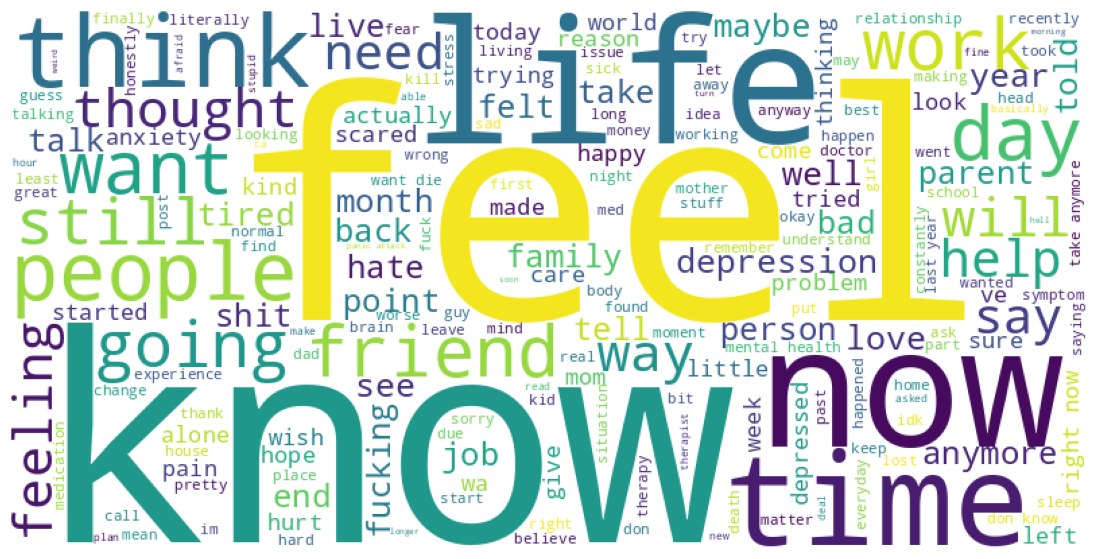

In [22]:
plt.figure(figsize = (15,7))
plt.imshow(wordcloud)
plt.axis('off')

plt.show()

In [23]:
df.head()

,statement,status,preprocessed
0,oh my gosh,Anxiety,[gosh]
1,"trouble sleeping, confused mind, restless hear...",Anxiety,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,"[wrong, back, dear, forward, doubt, stay, rest..."
3,I've shifted my focus to something else but I'...,Anxiety,"[shifted, focus, still, worried]"
4,"I'm restless and restless, it's been a month n...",Anxiety,"[restless, restless, month, now, boy, mean]"


In [24]:
df['status'].values

array(['Anxiety', 'Anxiety', 'Anxiety', ..., 'Anxiety', 'Anxiety',
       'Anxiety'], dtype=object)

In [25]:
encoder = LabelEncoder()
labels = encoder.fit_transform(df['status'].values)
labels

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
X = df['preprocessed'].values
print(X[:5])

[list(['gosh'])
 list(['trouble', 'sleeping', 'confused', 'mind', 'restless', 'heart', 'tune'])
 list(['wrong', 'back', 'dear', 'forward', 'doubt', 'stay', 'restless', 'restless', 'place'])
 list(['shifted', 'focus', 'still', 'worried'])
 list(['restless', 'restless', 'month', 'now', 'boy', 'mean'])]


In [27]:
X.shape

(52681,)

In [28]:
labels.shape

(52681,)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2, random_state = 42)

In [30]:
vectorizer = TfidfVectorizer(max_features=50000, ngram_range= (1,2))
X_train_tfidf = vectorizer.fit_transform([' '.join(i) for i in X_train])
X_test_tfidf = vectorizer.transform([' '.join(i) for i in X_test])

In [31]:
models = {                        
"Logistic Regression":LogisticRegression(C = 10, max_iter=100),
"Random Forest":RandomForestClassifier(n_estimators=100),
"Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5),
"XGBoost": XGBClassifier(n_estimators=100,learning_rate =0.1, max_depth=5)
}

In [32]:
results = {}

for model_name, model in models.items():

    model.fit(X_train_tfidf, y_train)
    predicted_y = model.predict(X_test_tfidf)
    
    results[model_name] = {
        'model': model,
        'score': accuracy_score(y_test, predicted_y),
    }
    
    print(model_name)
    print(results[model_name])
    print('-'*100)


Logistic Regression
{'model': LogisticRegression(C=10), 'score': 0.7690044604726203}
----------------------------------------------------------------------------------------------------
Random Forest
{'model': RandomForestClassifier(), 'score': 0.6973521875296574}
----------------------------------------------------------------------------------------------------
Gradient Boosting
{'model': GradientBoostingClassifier(max_depth=5), 'score': 0.7478409414444339}
----------------------------------------------------------------------------------------------------
XGBoost
{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=No

In [35]:
def print_confusion_matrix(y_test,model):
    
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_true=y_test, y_pred=y_pred)
    con = confusion_matrix(y_true=y_test, y_pred=y_pred)
    labels = encoder.classes_
    ax = sns.heatmap(con, annot = True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    ax.set_title(f'{type(model).__name__} - {acc:.2}%')
    plt.show()

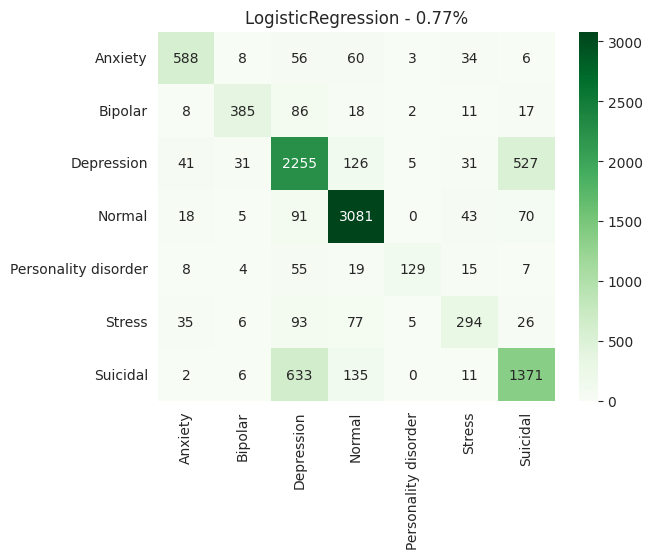

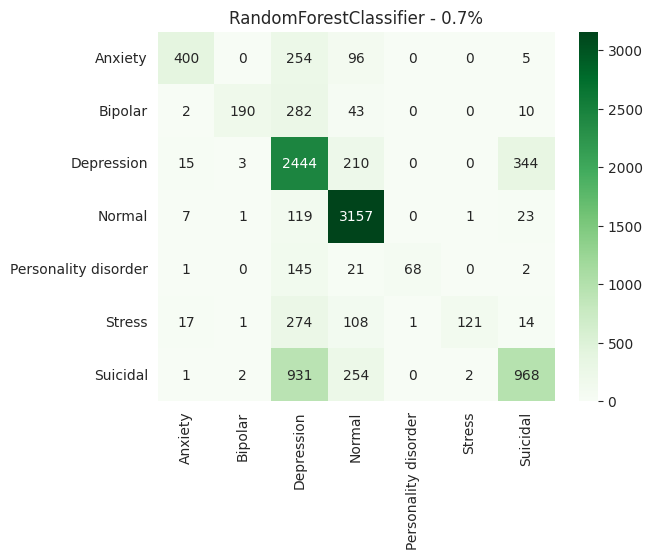

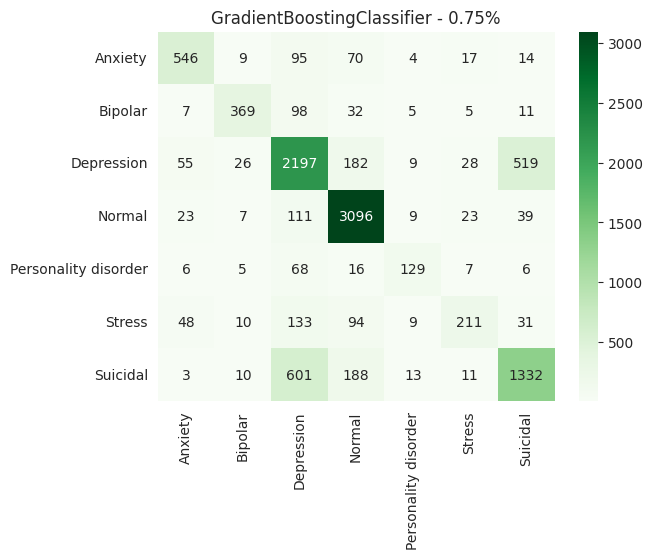

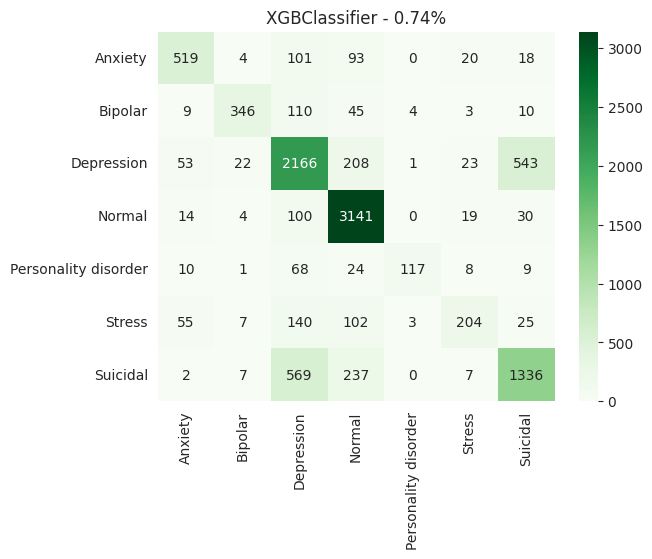

In [34]:
for model_name in results: 
    model = results[model_name]['model']
    print_confusion_matrix(y_test,model)